In [1]:
import pandas as pd
import cobra
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linprog
import scipy

# Community modeling

In this notebook we will implement a method to create community models of two or more species specific metabolic models using cobrapy.

In [2]:
model_DP = cobra.io.read_sbml_model("models/consistent_DP_SNM.xml")
model_SA = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print("Growth: ", model_DP.slim_optimize())
print("Growth: ", model_SA.slim_optimize())

Growth:  0.2823653925322476
Growth:  2.558694612613393


In [3]:
for rec in model_SA.reactions:
    rec.lower_bound = max(rec.lower_bound, -1000)
    rec.upper_bound = min(rec.upper_bound, 1000)

In [4]:
snm3 = pd.read_csv("SNM3.csv", sep =";")
snm3.head()

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037


In [5]:
BIOMASS_DP = "Growth" 
BIOMASS_SA = "BIOMASS_iYS_wild_type"
models = [model_DP.copy(), model_SA.copy()]

## 1) Constructing of community model explicitely

Here we introduce only shuttle reactions for reactions that are common in the uptake/sekretion reactions of the individual models!

In [6]:
summary_DP = model_DP.summary()
uptake_DP = summary_DP.uptake_flux.index.to_list()
uptake_DP = [rec for rec in uptake_DP if "Sink" not in rec]
secretion_DP = summary_DP.secretion_flux["flux"]
secretion_DP = secretion_DP[secretion_DP < 0].index.to_list()
secretion_DP = [rec for rec in secretion_DP if "Sink" not in rec]

In [7]:
summary_SA = model_SA.summary()
uptake_SA = summary_SA.uptake_flux.index.to_list()
uptake_SA = [rec for rec in uptake_SA if "SK" not in rec]
secretion_SA = summary_SA.secretion_flux["flux"]
secretion_SA = secretion_SA[secretion_SA < 0].index.to_list()
secretion_SA = [rec for rec in secretion_SA if "SK" not in rec]

In [8]:
# Common up/sekretion from SA to DP
up_sek_SA_DP = []
for sek in secretion_SA:
    for up in uptake_DP:
        if str(sek) == str(up):
            up_sek_SA_DP.append(str(sek))
up_sek_SA_DP

[]

In [9]:
# Common up/sekretion from DP to SA
up_sek_DP_SA = []
for sek in secretion_DP:
    for up in uptake_SA:
        if str(sek) == str(up):
            up_sek_DP_SA.append(str(sek))
up_sek_DP_SA

['EX_orn_e']

In [10]:
shared_uptake = list(set(uptake_DP).intersection(set(uptake_SA)))
shared_secretion = list(set(secretion_DP).intersection(set(secretion_SA)))
shared_secup = list(set(secretion_DP).intersection(set(uptake_SA)))
shared_upsec = list(set(uptake_DP).intersection(set(secretion_SA)))
total_shared = shared_uptake + shared_secretion + shared_secup + shared_upsec # There are no shared -> uptake, uptake -> shared pairs...
total_shared 

['EX_phe__L_e',
 'EX_ribflv_e',
 'EX_zn2_e',
 'EX_mn2_e',
 'EX_val__L_e',
 'EX_arg__L_e',
 'EX_cys__L_e',
 'EX_leu__L_e',
 'EX_k_e',
 'EX_glc__D_e',
 'EX_fe2_e',
 'EX_so4_e',
 'EX_o2_e',
 'EX_glu__L_e',
 'EX_mg2_e',
 'EX_thm_e',
 'EX_his__L_e',
 'EX_cl_e',
 'EX_trp__L_e',
 'EX_nac_e',
 'EX_lys__L_e',
 'EX_na1_e',
 'EX_glyclt_e',
 'EX_h2o_e',
 'EX_co2_e',
 'EX_orn_e']

In [11]:
# Check for single MBR with uptake reactions as medium
with model_DP:
    medium = dict([(id, 10) for id in uptake_DP])
    medium["EX_o2_e"] = 20
    model_DP.medium = medium
    print(model_DP.slim_optimize())

0.28236539253225407


In [12]:
with model_SA:
    medium = dict([(id, 10) for id in uptake_SA])
    medium["EX_o2_e"] = 20
    model_SA.medium = medium
    print(model_SA.slim_optimize())

2.558694612613398


In [13]:
def create_stoichiometry_matrix(model):
    metabolites = model.metabolites 
    reactions = model.reactions 
    S = np.zeros((len(metabolites), len(reactions)))
    
    met_id = dict()
    rec_id = dict()
    for i,reaction in enumerate(model.reactions):
        rec_id[reaction.id] = i
        for metabolite, stoich in reaction.metabolites.items():
            met_id[metabolite.id] = int(metabolites.index(metabolite))
            S[metabolites.index(metabolite), i] = stoich
    return S, met_id, rec_id 

In [14]:
class Model():
    def __init__(self, model, biomass_function):
        """ This is a new class of metabolic model, capable of flux balance analysis
        Attributes:
        models (list): CobraPy models of single organisms which will be used in construction
        biomass_reactions (list): List of strings containing the ids for the growth reactions
        """
        self.biomass_function = biomass_function
        self.model = model
        self.id = model.id
        # Compute stoichimetry_matrix
        S, met_id, rec_id = create_stoichiometry_matrix(model)
        self.num_reactions = S.shape[1]
        self.num_metabolites = S.shape[0]
        self.stoichiometry_matrix = scipy.sparse.csr_matrix(S)
        self.met_id = met_id
        self.rec_id = rec_id 
        # Set objective
        idx = self.rec_id[biomass_function]
        c = np.zeros(self.num_reactions)
        c[idx] = 1
        self.objective_c = c
        # Set bounds
        self._reset_bounds()
    
    @property
    def reactions(self):
        return self.model.reactions
    @property
    def exchanges(self):
        return self.model.exchanges
    @property
    def metabolites(self):
        return self.model.metabolites
    @property
    def medium(self):
        return self.model.medium

    def set_medium(self, medium):
        ex_ids = [ex.id for ex in self.exchanges]
        new_med = {}
        for key,val in medium.items():
            if key in ex_ids:
                new_med[key] = val
        self.model.medium = new_med
        self._reset_bounds()
        
    def optimize(self, disp=False):
        sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
        sol["fun"] = -sol["fun"] # As we have to minimize
        return sol 
    
    def slim_optimize(self, disp=False):
        sol = self.optimize(disp=disp)
        return sol["fun"]

    def summary(self):
        sol = self.optimize()
        flux = sol["x"]
        ex_ids = [ex.id for ex in self.exchanges]
        fluxes = []
        for ex in ex_ids:
            idx = self.rec_id[ex]
            fluxes.append(flux[idx])
        summary_df = pd.DataFrame({"Exchange reaction": ex_ids, "Flux": fluxes})
        summary_df.sort_values(["Flux"], inplace=True)
        return summary_df

    def _reset_bounds(self):
        self.bounds = []
        for rec in self.model.reactions:
            self.bounds.append((rec.lower_bound, rec.upper_bound))

    def __add__(self, model2):
        """ Adding another model creates a community model """
        return CommunityModel([self,model2], [1.,1.])
    

In [15]:
class CommunityModel(Model):
    def __init__(self, models, weight, shared_exchanges=None):
        self.models = models
        self.id = "|".join([model.id for model in models])
        self.weight = weight
        if shared_exchanges == None:
            self.shared_exchanges = []
            for model in models:
                for rec in model.exchanges:
                    if rec.id not in self.shared_exchanges:
                        self.shared_exchanges.append(rec.id)
        else:
            self.shared_exchanges = shared_exchanges
        # Create community stoichimetry matrix with shuttel reactions!
        self._shifts = [len(self.shared_exchanges)]
        for i,model in enumerate(models):
            self._shifts.append(self._shifts[i] + model.num_reactions)
        S_EX = -np.eye(self._shifts[0])
        matrices = [S_EX] + [m.stoichiometry_matrix.todense() for m in models]
        S = scipy.linalg.block_diag(*matrices)
        self.num_reactions = S.shape[1]
        self.num_metabolites = S.shape[0]
        for i, id in enumerate(self.shared_exchanges):
            for j,model in enumerate(models):
                if id in model.rec_id:
                    S[i,self._shifts[j] + model.rec_id[id]] = 1
        self.stoichiometry_matrix = scipy.sparse.csr_matrix(S)
        # Cretae objective:
        self._weighted_objective(weight)
        # Create bounds
        self._reset_bounds()
    
    @property
    def reactions(self):
        return [model.reactions for model in self.models]
    @property
    def exchanges(self):
        return self.shared_exchanges
    @property
    def metabolites(self):
        return [model.metabolites for model in self.models]
    @property
    def medium(self):
        medium = {}
        for model in self.models:
            for key,val in model.medium:
                medium[key] = val
        return medium

    def _weighted_objective(self, weight):
        self.weight = weight
        self.objective_c = np.zeros(self._shifts[0])
        for i,model in enumerate(self.models):
            self.objective_c = np.append(self.objective_c, weight[i]*model.objective_c)
    def _reset_bounds(self):
        self.bounds = []
        for id in self.shared_exchanges:
            min_lower_bound = 0
            for model in self.models:
                if id in model.rec_id:
                    rec = model.reactions.get_by_id(id)
                    if rec.lower_bound < min_lower_bound:
                        min_lower_bound = rec.lower_bound 
            self.bounds.append((min_lower_bound, 1000))
        for model in self.models:
            self.bounds += model.bounds

    def set_medium(self, medium):
        for model in self.models:
            model.set_medium(medium)
        self._reset_bounds()

    def compute_alpha_weightings(self, alpha, maxbiomass=0.1):
        assert alpha <= 1 and alpha >= 0
        assert len(self.models) == 2
        alphas = np.array([alpha,1-alpha])
        # Alpha objective...
        c = np.zeros(self._shifts[0])
        for i, model in enumerate(self.models):
            c = np.append(c, model.objective_c)
        # Biomoss constraints
        c_mask = (c > 0)
        A_ub = np.zeros((2,len(c)))
        A_ub[0,c_mask] = np.array([1,0])
        A_ub[1,c_mask] = np.array([0,1])
        b_ub = alphas*maxbiomass
        sol = linprog(-c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), A_ub = A_ub, b_ub=b_ub, bounds=self.bounds, method="highs")
        fluxes = sol["x"]
        growths = fluxes[c > 0]
        summary = self.summary(sol)
        return growths, fluxes,summary

    def summary(self, sol=None):
        if sol == None:
            sol = self.optimize()
        flux = sol["x"]
        ex_ids = self.shared_exchanges
        ex_flux = flux[:len(ex_ids)]
        df_ex = pd.DataFrame({"Exchanges": ex_ids, "Flux": ex_flux})
        df_ex.sort_values(["Flux"], inplace=True)
        for i,model in enumerate(self.models):
            shuttel_ids = self.shared_exchanges
            id = str(model.id) + " Shuttel Flux"
            df_ex[id] = 0.
            for sh in shuttel_ids:
                idx = model.rec_id[sh]
                df_ex[id][ex_ids.index(sh)] = flux[self._shifts[i] +idx]
        
        return df_ex
    
    def set_weights(self, weight):
        self._weighted_objective(weight)
    
    def get_model_growths(self):
        mask = self.objective_c != 0
        sol = self.optimize()
        flux = sol["x"]
        return flux[mask]

In [19]:
import json
compm_SA = json.loads(open("compm_SA.json").read())
compm_DP = json.loads(open("compm_DP.json").read())

In [20]:
compm = dict()
for key, val in compm_SA.items():
    compm[key] = val 
for key, val in compm_DP.items():
    compm[key] = val 

In [21]:
model_DP = Model(model_DP, BIOMASS_DP)
model_SA = Model(model_SA, BIOMASS_SA)

In [22]:
# Community model
model = CommunityModel([model_SA, model_DP], [1.,1.], shared_exchanges=total_shared)
print("Weights 1:1: ", model.slim_optimize())
growths = model.get_model_growths()
print("SA growth: ", growths[0])
print("DP growth: ", growths[1])

Weights 1:1:  2.558694612613309
SA growth:  2.558694612613309
DP growth:  -0.0


<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Unknown solver options: sparse
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})


In [24]:
model.set_medium(compm)

In [25]:
growths = model.get_model_growths()
print("SA growth: ", growths[0])
print("DP growth: ", growths[1])

SA growth:  2.558694612613441
DP growth:  -9.732222301975288e-13


<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Unknown solver options: sparse
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})


In [26]:
df = model.summary()
df

<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Unknown solver options: sparse
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-15-6ce49dc6bb8e>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex[id][ex_ids.index(sh)] = flux[self._shifts[i] +idx]


,Exchanges,Flux,iYS854 Shuttel Flux,DP_83VPs_KB5 Shuttel Flux
12,EX_o2_e,-20.000000,-20.000000,3.801404e-13
13,EX_glu__L_e,-10.000000,-10.000000,4.973799e-13
9,EX_glc__D_e,-10.000000,-10.000000,3.417711e-11
6,EX_cys__L_e,-10.000000,-0.419275,-9.580725e+00
25,EX_orn_e,-10.000000,-10.000000,-0.000000e+00
21,EX_na1_e,-5.090523,-5.090523,8.881784e-14
4,EX_val__L_e,-0.940389,-0.940389,3.988246e-13
20,EX_lys__L_e,-0.922344,-0.922344,3.234247e-13
7,EX_leu__L_e,-0.803458,-0.803458,4.246603e-13
8,EX_k_e,-0.475124,-0.475124,1.491914e-13


In [32]:
# Without shared exchanges we shoud have single growth..
model = CommunityModel([model_SA, model_DP], [1.,1.], shared_exchanges=[])
print("Weights 1:1: ", model.slim_optimize())
growths = model.get_model_growths()
print("SA growth: ", growths[0])
print("DP growth: ", growths[1])
model.summary()

Weights 1:1:  2.841060005144088
SA growth:  2.5586946126118377
DP growth:  0.28236539253225035


<ipython-input-27-5ceee4aecab6>:49: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-27-5ceee4aecab6>:49: OptimizeWarning: Unknown solver options: sparse
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})


,Exchanges,Flux,iYS854 Shuttel Flux,DP_83VPs_KB5 Shuttel Flux


In [33]:
# Without shared exchanges o2, we shoud reduce SA gorwth
model = CommunityModel([model_SA, model_DP], [1.,1.], shared_exchanges=["EX_o2_e"])
print("Weights 1:1: ", model.slim_optimize())
growths = model.get_model_growths()
print("SA growth: ", growths[0])
print("DP growth: ", growths[1])
model.summary()

Weights 1:1:  2.8321356917302096
SA growth:  2.549770299197961
DP growth:  0.2823653925322486


<ipython-input-27-5ceee4aecab6>:49: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-27-5ceee4aecab6>:49: OptimizeWarning: Unknown solver options: sparse
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-28-6ce49dc6bb8e>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex[id][ex_ids.index(sh)] = flux[self._shifts[i] +idx]


,Exchanges,Flux,iYS854 Shuttel Flux,DP_83VPs_KB5 Shuttel Flux
0,EX_o2_e,-20.0,-19.874221,-0.125779


In [27]:
model = CommunityModel([model_SA, model_DP], [1.,10.], shared_exchanges=total_shared)
print("Weights 1:10: ", model.slim_optimize())
growths = model.get_model_growths()
print("SA growth: ", growths[0])
print("DP growth: ", growths[1])

Weights 1:10:  2.904521879693608
SA growth:  2.175506751508334
DP growth:  0.07290151281852739


<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Unknown solver options: sparse
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})


In [28]:
df = model.summary()
df

<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-14-5ceee4aecab6>:49: OptimizeWarning: Unknown solver options: sparse
  sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
<ipython-input-15-6ce49dc6bb8e>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex[id][ex_ids.index(sh)] = flux[self._shifts[i] +idx]


,Exchanges,Flux,iYS854 Shuttel Flux,DP_83VPs_KB5 Shuttel Flux
12,EX_o2_e,-20.000000,-19.967526,-0.032474
13,EX_glu__L_e,-10.000000,-9.955735,-0.044265
9,EX_glc__D_e,-10.000000,-7.418185,-2.581815
6,EX_cys__L_e,-10.000000,-0.350182,-9.649818
25,EX_orn_e,-10.000000,-10.000000,-0.000000
21,EX_na1_e,-4.334777,-4.328171,-0.006606
4,EX_val__L_e,-0.829819,-0.799557,-0.030262
20,EX_lys__L_e,-0.808441,-0.784214,-0.024227
7,EX_leu__L_e,-0.714940,-0.683133,-0.031807
8,EX_k_e,-0.407854,-0.403970,-0.003885


In [25]:
df.to_csv("exchange_summary_shuttels_only_uptake_sekretion_weight_1_10.csv")

## Investigate weighting...

We will fix $\nu_{comm} = 0.1$. That is the total biomass will be fixed to 0.3. Now we will compute for several $\alpha \in (0,1)$ following optimization problem:
$$ \max \  \nu_{DP} + \nu_{SA} \text{ subject to usuall constraints and }  \nu_{SA} \leq \alpha \cdot 0.3 \quad  \nu_{DP} \leq (1-\alpha) \cdot 0.3$$

In [26]:
model.set_weights([1,10])

In [27]:
summaries = dict()
for alpha in [i/10 for i in range(1,10)]:
    growths, fluxes, summary = model.compute_alpha_weightings(alpha, 0.3)
    print(growths)
    summaries[alpha] = summary 

ipykernel_launcher:87: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
ipykernel_launcher:87: OptimizeWarning: Unknown solver options: sparse
ipykernel_launcher:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[0.03 0.27]
[0.06 0.24]
[0.09 0.21]
[0.12 0.18]
[0.15 0.15]
[0.18 0.12]
[0.21 0.09]
[0.24 0.06]
[0.27 0.03]


In [28]:
df_full = pd.concat(summaries, join="outer", axis=1)

In [29]:
df_full

0.1                                                           \
      Exchanges       Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0       EX_o2_e -20.000000          -19.879730                 -0.120270   
1   EX_val__L_e  -0.123106           -0.011026                 -0.112081   
2   EX_lys__L_e  -0.100542           -0.010814                 -0.089727   
3       EX_cl_e  -0.016015           -0.000149                 -0.015866   
4   EX_leu__L_e  -0.127222           -0.009420                 -0.117802   
5      EX_so4_e  -0.005979           -0.000124                 -0.005856   
6   EX_phe__L_e  -0.087927           -0.003429                 -0.084498   
7      EX_mg2_e  -0.023391           -0.000248                 -0.023143   
8   EX_trp__L_e  -0.015323           -0.000460                 -0.014863   
9      EX_zn2_e  -0.008609           -0.000010                 -0.008600   
10  EX_ribflv_e  -0.000126           -0.000009                 -0.000117   
11  EX_glc__D_e -10.000000           -0.437922                 -9.562078   
12       EX_k_e  -0.019958           -0.005571                 -0.014387   
13     EX_thm_e  -0.000072           -0.000013                 -0.000058   
14  EX_cys__L_e -10.000000           -0.005409                 -9.994591   
15     EX_na1_e  -0.084152           -0.059685                 -0.024467   
16     EX_mn2_e  -0.010259           -0.000020                 -0.010239   
17  EX_glu__L_e  -0.178831           -0.014890                 -0.163941   
18     EX_nac_e  -0.003218           -0.000003                 -0.003215   
19     EX_fe2_e  -0.020588           -0.000443                 -0.020145   
20  EX_arg__L_e   6.609367            9.926067                 -3.316701   
21  EX_his__L_e  -0.026579           -0.001807                 -0.024771   
22     EX_co2_e  33.520756           29.798540                  3.722216   
23  EX_glyclt_e   0.000188            0.000013                  0.000175   
24     EX_h2o_e  10.402209           20.402209                -10.000000   

            0.2                                                           \
      Exchanges       Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0       EX_o2_e -20.000000          -19.893093                 -0.106907   
1   EX_val__L_e  -0.121679           -0.022052                 -0.099627   
2   EX_lys__L_e  -0.101386           -0.021628                 -0.079758   
3       EX_cl_e  -0.014400           -0.000297                 -0.014103   
4   EX_leu__L_e  -0.123553           -0.018841                 -0.104713   
5      EX_so4_e  -0.005452           -0.000248                 -0.005205   
6   EX_phe__L_e  -0.081967           -0.006857                 -0.075109   
7      EX_mg2_e  -0.021067           -0.000495                 -0.020572   
8   EX_trp__L_e  -0.014132           -0.000920                 -0.013211   
9      EX_zn2_e  -0.007664           -0.000019                 -0.007644   
10  EX_ribflv_e  -0.000122           -0.000018                 -0.000104   
11  EX_glc__D_e -10.000000           -1.500375                 -8.499625   
12       EX_k_e  -0.023930           -0.011141                 -0.012788   
13     EX_thm_e  -0.000079           -0.000027                 -0.000052   
14  EX_cys__L_e -10.000000           -0.010819                 -9.989181   
15     EX_na1_e  -0.141119           -0.119370                 -0.021749   
16     EX_mn2_e  -0.009141           -0.000039                 -0.009101   
17  EX_glu__L_e  -0.459208           -0.313483                 -0.145725   
18     EX_nac_e  -0.002863           -0.000005                 -0.002858   
19     EX_fe2_e  -0.018792           -0.000885                 -0.017907   
20  EX_arg__L_e   7.595297           10.267200                 -2.671903   
21  EX_his__L_e  -0.025634           -0.003615                 -0.022019   
22     EX_co2_e  32.345947           29.313585                  3.032362   
23  EX_glyclt_e   0.000182            0.000027             

In [30]:
df_full.to_csv("summaries_all_alpha_weight_1_10_only_upatake_sekreation.csv")

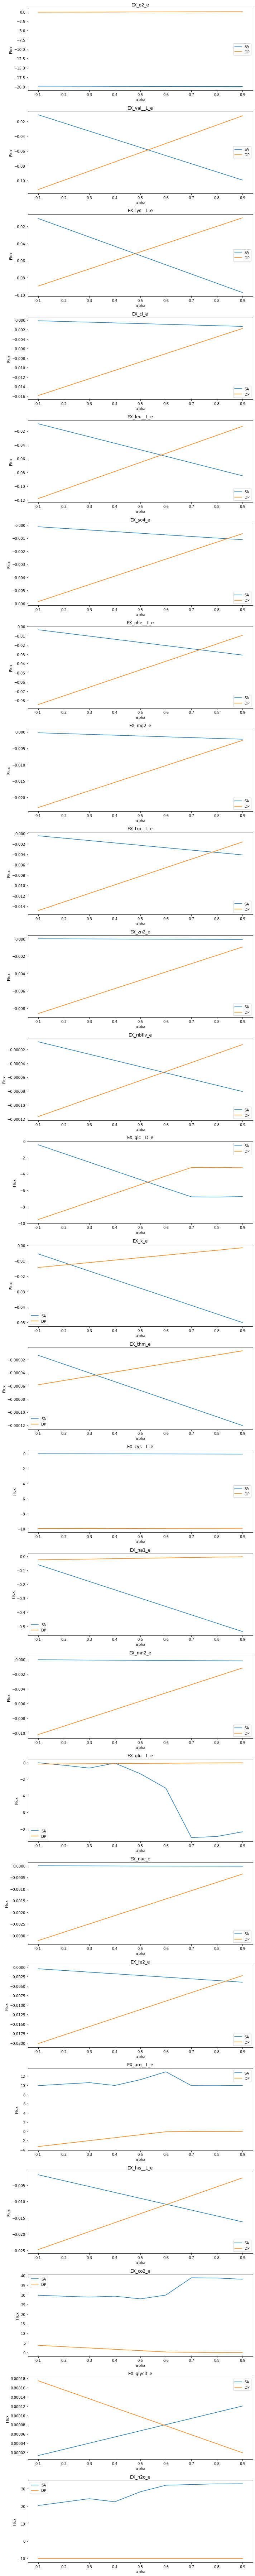

In [31]:
fig, axes = plt.subplots(len(df_full), figsize=(10,100))
alphas = sorted(list(set(map(lambda x: x[0], df_full.columns))))
titles = df_full[0.1]["Exchanges"].tolist()
for j, row in df_full.iterrows():
    SA_y = []
    DP_y = []
    for i in range(len(alphas)):
        SA_y.append(row[alphas[i]]["iYS854 Shuttel Flux"])
        DP_y.append(row[alphas[i]]["DP_83VPs_KB5 Shuttel Flux"])
    axes[j].plot(alphas, SA_y)
    axes[j].plot(alphas, DP_y)
    axes[j].set_title(titles[j])
    axes[j].set_ylabel("Flux")
    axes[j].set_xlabel("alpha")
    axes[j].legend(["SA", "DP"])
plt.tight_layout()
plt.savefig("flux_per_alpha_weights_1_10.pdf")

In [32]:
model.set_weights([1,1])

In [33]:
summaries = dict()
for alpha in [i/10 for i in range(1,10)]:
    growths, fluxes, summary = model.compute_alpha_weightings(alpha, 0.3)
    summaries[alpha] = summary 

ipykernel_launcher:87: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
ipykernel_launcher:87: OptimizeWarning: Unknown solver options: sparse
ipykernel_launcher:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
df_full = pd.concat(summaries, join="outer", axis=1)

In [35]:
df_full.to_csv("summaries_all_alpha_weight_1_1.csv")

In [36]:
df_full

0.1                                                           \
      Exchanges       Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0       EX_o2_e -20.000000          -19.879730                 -0.120270   
1   EX_val__L_e  -0.123106           -0.011026                 -0.112081   
2   EX_lys__L_e  -0.100542           -0.010814                 -0.089727   
3       EX_cl_e  -0.016015           -0.000149                 -0.015866   
4   EX_leu__L_e  -0.127222           -0.009420                 -0.117802   
5      EX_so4_e  -0.005979           -0.000124                 -0.005856   
6   EX_phe__L_e  -0.087927           -0.003429                 -0.084498   
7      EX_mg2_e  -0.023391           -0.000248                 -0.023143   
8   EX_trp__L_e  -0.015323           -0.000460                 -0.014863   
9      EX_zn2_e  -0.008609           -0.000010                 -0.008600   
10  EX_ribflv_e  -0.000126           -0.000009                 -0.000117   
11  EX_glc__D_e -10.000000           -0.437922                 -9.562078   
12       EX_k_e  -0.019958           -0.005571                 -0.014387   
13     EX_thm_e  -0.000072           -0.000013                 -0.000058   
14  EX_cys__L_e -10.000000           -0.005409                 -9.994591   
15     EX_na1_e  -0.084152           -0.059685                 -0.024467   
16     EX_mn2_e  -0.010259           -0.000020                 -0.010239   
17  EX_glu__L_e  -0.178831           -0.014890                 -0.163941   
18     EX_nac_e  -0.003218           -0.000003                 -0.003215   
19     EX_fe2_e  -0.020588           -0.000443                 -0.020145   
20  EX_arg__L_e   6.609367            9.926067                 -3.316701   
21  EX_his__L_e  -0.026579           -0.001807                 -0.024771   
22     EX_co2_e  33.520756           29.798540                  3.722216   
23  EX_glyclt_e   0.000188            0.000013                  0.000175   
24     EX_h2o_e  10.402209           20.402209                -10.000000   

            0.2                                                           \
      Exchanges       Flux iYS854 Shuttel Flux DP_83VPs_KB5 Shuttel Flux   
0       EX_o2_e -20.000000          -19.893093                 -0.106907   
1   EX_val__L_e  -0.121679           -0.022052                 -0.099627   
2   EX_lys__L_e  -0.101386           -0.021628                 -0.079758   
3       EX_cl_e  -0.014400           -0.000297                 -0.014103   
4   EX_leu__L_e  -0.123553           -0.018841                 -0.104713   
5      EX_so4_e  -0.005452           -0.000248                 -0.005205   
6   EX_phe__L_e  -0.081967           -0.006857                 -0.075109   
7      EX_mg2_e  -0.021067           -0.000495                 -0.020572   
8   EX_trp__L_e  -0.014132           -0.000920                 -0.013211   
9      EX_zn2_e  -0.007664           -0.000019                 -0.007644   
10  EX_ribflv_e  -0.000122           -0.000018                 -0.000104   
11  EX_glc__D_e -10.000000           -1.500375                 -8.499625   
12       EX_k_e  -0.023930           -0.011141                 -0.012788   
13     EX_thm_e  -0.000079           -0.000027                 -0.000052   
14  EX_cys__L_e -10.000000           -0.010819                 -9.989181   
15     EX_na1_e  -0.141119           -0.119370                 -0.021749   
16     EX_mn2_e  -0.009141           -0.000039                 -0.009101   
17  EX_glu__L_e  -0.459208           -0.313483                 -0.145725   
18     EX_nac_e  -0.002863           -0.000005                 -0.002858   
19     EX_fe2_e  -0.018792           -0.000885                 -0.017907   
20  EX_arg__L_e   7.595297           10.267200                 -2.671903   
21  EX_his__L_e  -0.025634           -0.003615                 -0.022019   
22     EX_co2_e  32.345947           29.313585                  3.032362   
23  EX_glyclt_e   0.000182            0.000027             

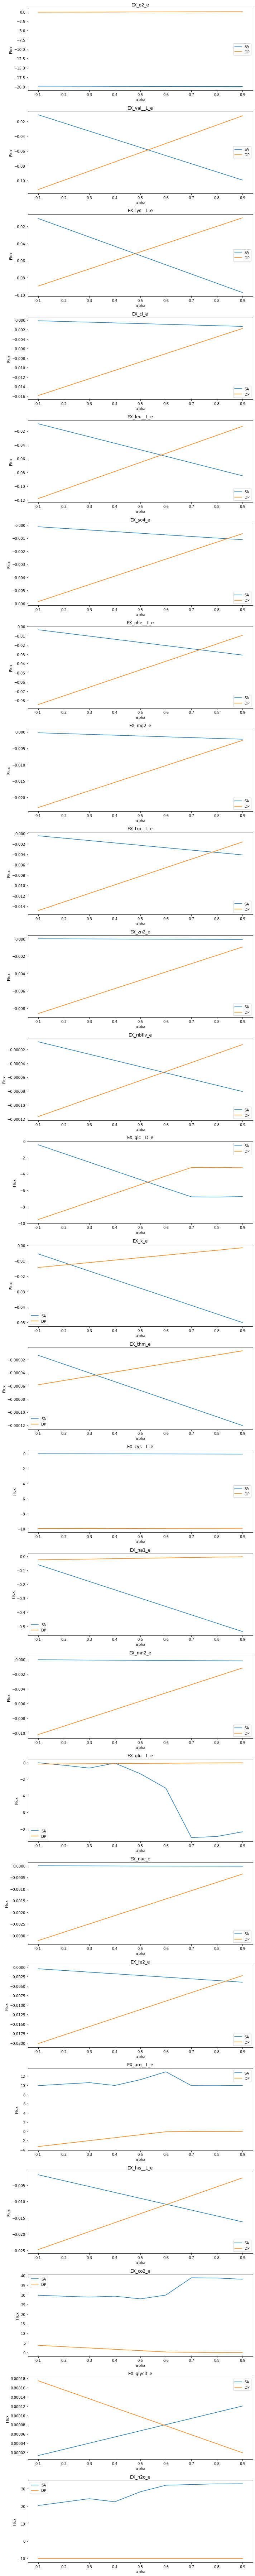

In [37]:
fig, axes = plt.subplots(len(df_full), figsize=(10,100))
alphas = sorted(list(set(map(lambda x: x[0], df_full.columns))))
titles = df_full[0.1]["Exchanges"].tolist()
for j, row in df_full.iterrows():
    SA_y = []
    DP_y = []
    for i in range(len(alphas)):
        SA_y.append(row[alphas[i]]["iYS854 Shuttel Flux"])
        DP_y.append(row[alphas[i]]["DP_83VPs_KB5 Shuttel Flux"])
    axes[j].plot(alphas, SA_y)
    axes[j].plot(alphas, DP_y)
    axes[j].set_title(titles[j])
    axes[j].set_ylabel("Flux")
    axes[j].set_xlabel("alpha")
    axes[j].legend(["SA", "DP"])
plt.tight_layout()
plt.savefig("flux_per_alpha_weights_1_1.pdf")